In [187]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.ensemble import RandomForestClassifier


In [188]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)


In [189]:
# import the shots dataset
shots = pd.read_csv("../datasets/23_24_shotmaps.csv", index_col='Unnamed: 0')

shots = shots.fillna(0)

y = shots.outcome_goal
X = shots[
    [
        "playerCoordinates.x",
        "playerCoordinates.y",
        "playerCoordinates.z",
        "goalMouthCoordinates.x",
        "goalMouthCoordinates.y",
        "goalMouthCoordinates.z",
        "shot_sit_assisted",
        "shot_sit_corner",
        "shot_sit_free-kick",
        "shot_sit_set-piece",
        "bodyPart_left-foot",
        "bodyPart_right-foot",
    ]
]


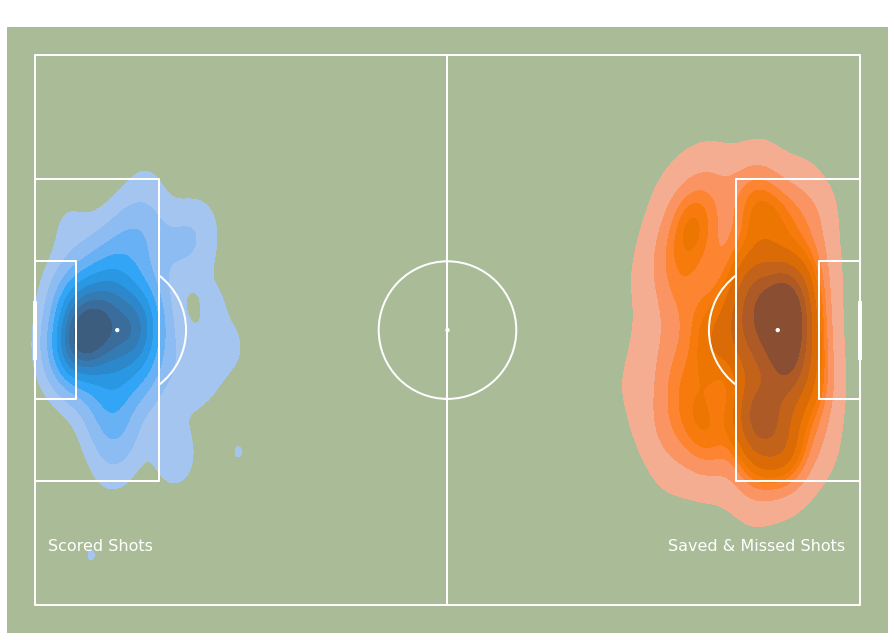

In [190]:
# create a split view plot
pitch = Pitch(
    pitch_color="#aabb97",
    line_color="white",
    stripe=False,
)

fig, ax = pitch.draw(figsize=(16, 9))

sns.kdeplot(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.x'] + 2.5,
    y=90 - shots[shots["outcome_goal"] == 1]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="Goal",
)

sns.kdeplot(
    x=117.5 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    y=90 - shots[shots["outcome_goal"] == 0]['playerCoordinates.y'],
    fill=True,
    zorder=-1,
    alpha=1,
    label="No Goal",
)

ax.annotate("Scored Shots", xy=(2, 72), c="White", fontsize=16)
ax.annotate("Saved & Missed Shots", xy=(92, 72), c="White", fontsize=16)

plt.title("Shotmap from Premier League Games 2023-2024 Season", c="White", fontsize=20)

plt.savefig("../assets/shotmap.png")
plt.show()

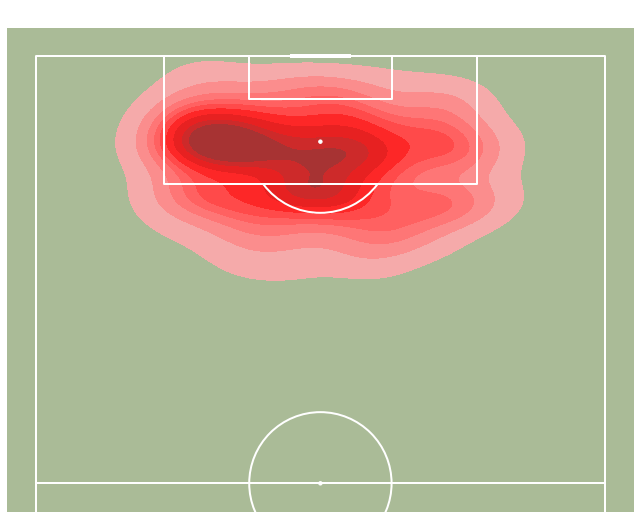

In [191]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

sns.kdeplot(
    x=shots[shots["outcome_block"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['playerCoordinates.x'],
    fill=True,
    zorder=-1,
    color='red'
)

plt.title("Density of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

## Model Architecture & Compiling

In [192]:
tf.random.set_seed(111)

In [193]:
# split the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=111
)

In [194]:
xg_model = keras.Sequential()

xg_model.add(layers.Input(shape=X_train.shape[1]))

xg_model.add(layers.Dense(8, activation="tanh", input_shape=(X_train.shape,)))
xg_model.add(layers.Dense(16, activation="tanh"))
xg_model.add(layers.Dense(32, activation="tanh"))
xg_model.add(layers.Dropout(0.2))
xg_model.add(layers.Dense(64, activation="tanh"))

xg_model.add(layers.Dense(1, activation="sigmoid"))

In [195]:
xg_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 104       
                                                                 
 dense_21 (Dense)            (None, 16)                144       
                                                                 
 dense_22 (Dense)            (None, 32)                544       
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 64)                2112      
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,969
Trainable params: 2,969
Non-traina

In [196]:
xg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(
    min_delta=1e-5,
    patience=15,
    mode="min",
    monitor="val_loss",
    restore_best_weights=True,
)
# story history
xg_history = xg_model.fit(
    X_train, y_train, validation_split=0.2, callbacks=callback, epochs=200, verbose=1
)

Epoch 1/200
23/23 [==============================] - 1s 8ms/step - loss: 0.6398 - accuracy: 0.6355 - val_loss: 0.5283 - val_accuracy: 0.8556
Epoch 2/200
23/23 [==============================] - 0s 2ms/step - loss: 0.5089 - accuracy: 0.8170 - val_loss: 0.4013 - val_accuracy: 0.8722
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 0.4057 - accuracy: 0.8687 - val_loss: 0.3190 - val_accuracy: 0.8833
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3519 - accuracy: 0.8771 - val_loss: 0.2825 - val_accuracy: 0.8944
Epoch 5/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3318 - accuracy: 0.8799 - val_loss: 0.2670 - val_accuracy: 0.9000
Epoch 6/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3260 - accuracy: 0.8799 - val_loss: 0.2554 - val_accuracy: 0.9000
Epoch 7/200
23/23 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.8855 - val_loss: 0.2516 - val_accuracy: 0.8944
Epoch 8/200
2

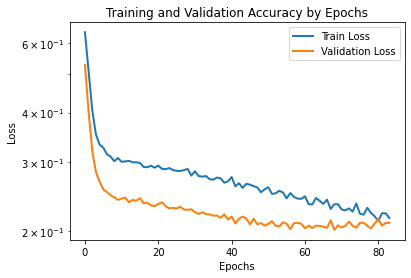

In [197]:
plt.title("Training and Validation Accuracy by Epochs")
plt.semilogy(xg_history.history["loss"], label="Train Loss", linewidth=2)
plt.semilogy(xg_history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.legend()

# Set the axes labels
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Alternate models for comparision

In [198]:
results = {}
for depth in range(1, 20):
    clf = RandomForestClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train, y_train)

    rf_pred_test = clf.predict_proba(X_test)[:,1]
    results[depth] = mean_squared_error(y_test, rf_pred_test)
    
optimal_depth = min(results, key=results.get)

In [199]:
clf = RandomForestClassifier(max_depth=optimal_depth, random_state=0)
clf.fit(X_train, y_train)

rf_pred = clf.predict_proba(X_scaled)[:,1]
rf_pred_test = clf.predict_proba(X_test)[:,1]
mean_squared_error(y_test, rf_pred_test)

0.07340040628879384

## Generate xG Predictions

In [200]:
# predict on full data
ann_pred = xg_model.predict(X_scaled)
ann_pred_test = xg_model.predict(X_test)
sofa_score_pred = shots[['xg']]

In [201]:
ann_mse = mean_squared_error(y_test, ann_pred_test)
rf_mse = mean_squared_error(y_test, rf_pred_test)
sofascore_mse = mean_squared_error(y, sofa_score_pred)

print(f'ANN Model MSE: {ann_mse:0.4f}')
print(f'RF Model MSE: {rf_mse:0.4f}')
print(f'Sofascore\'s Model MSE: {sofascore_mse:0.4f}')

ANN Model MSE: 0.0856
RF Model MSE: 0.0734
Sofascore's Model MSE: 0.0746


In [202]:
if ann_mse == min(ann_mse, rf_mse):
    shots["xG"] = ann_pred
else:
    shots['xG'] = rf_pred

## Plot xG by Player Coordinates

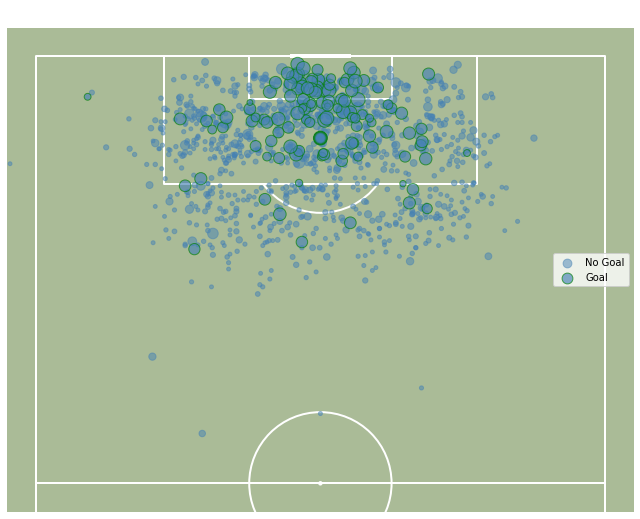

In [203]:
# create a split view plot
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_goal"] == 0]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 0]['playerCoordinates.x'],
    alpha=0.5,
    s=200 * shots[shots["outcome_goal"] == 0].xG + 15,
    c="steelblue",
    label="No Goal",
)

plt.scatter(
    x=shots[shots["outcome_goal"] == 1]['playerCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_goal"] == 1]['playerCoordinates.x'],
    alpha=0.65,
    s=200 * shots[shots["outcome_goal"] == 1].xG + 15,
    c="steelblue",
    edgecolor="green",
    label="Goal",
)

plt.title("Shotmap from Premier League Games '2023", c="White", fontsize=20)
plt.legend()

plt.savefig("../assets/xg_map.png")
plt.show()

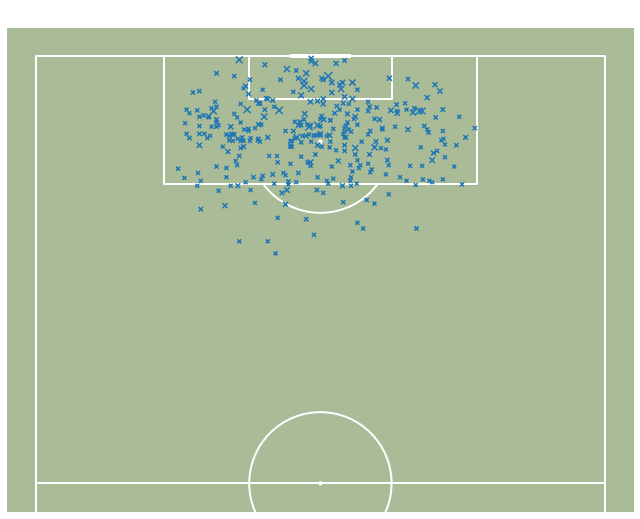

In [204]:
pitch = VerticalPitch(
    pitch_color="#aabb97", line_color="white", stripe=False, half=True
)

fig, ax = pitch.draw(figsize=(9, 9))

plt.scatter(
    x=shots[shots["outcome_block"] == 1]['blockCoordinates.y'] - 10,
    y=120 - shots[shots["outcome_block"] == 1]['blockCoordinates.x'],
    marker='x',
    s=200 * shots[shots["outcome_block"] == 1].xG + 15,
)

plt.title("Map of Blocked Shots from Premier League Games 23/24", c="White", fontsize=20)


plt.savefig("../assets/blocked_map.png")
plt.show()

## Compile xG stats by player and team

In [206]:
xg_for = shots.groupby('team')['xG'].sum().sort_values(ascending=False)
xg_against = shots.groupby('opponent')['xG'].sum().sort_values(ascending=False)


xg_table = pd.concat([xg_for, xg_against], axis=1, keys=['xG', 'xGA'])
xg_table['xG_differential'] = xg_table['xG'] - xg_table['xGA']

In [207]:
xg_table = xg_table.sort_values(by='xG_differential', ascending=False)
xg_table['Team'] = xg_table.index
xg_table.reset_index(drop=True, inplace=True)
xg_table.index = range(1, xg_table.shape[0] + 1)

In [208]:
# sort columns alphabetically
desired_columns = sorted([col for col in xg_table.columns])

# Reorder the columns based on the desired order
xg_table = xg_table[desired_columns]
xg_table['xG'] = xg_table['xG'].map('{:,.2f}'.format)
xg_table['xGA'] = xg_table['xGA'].map('{:,.2f}'.format)
xg_table['xG_differential'] = xg_table['xG_differential'].map('{:,.2f}'.format)

xg_table = xg_table.rename(columns={'xG_differential': 'xG Differential'})

xg_table.to_markdown('../assets/xG_table.md', index=True)
xg_table.to_csv('../assets/xG_table.csv', index=True)
xg_table

,Team,xG,xGA,xG Differential
1,Manchester City,10.554,2.331,8.223
2,Tottenham Hotspur,10.405,5.023,5.382
3,Arsenal,8.231,3.337,4.893
4,Crystal Palace,6.063,2.627,3.436
5,Brighton & Hove Albion,9.638,6.411,3.227
6,West Ham United,8.264,5.394,2.871
7,Liverpool,8.190,5.419,2.772
8,Brentford,7.941,5.425,2.517
9,Chelsea,6.414,4.537,1.877
10,Newcastle United,7.303,5.884,1.419


### Player xG table

In [209]:
xg_by_player = pd.DataFrame(shots.groupby('player.name')['xG'].sum().sort_values(ascending=False))

player_team = shots[['player.name', 'team']].drop_duplicates(subset='player.name')

xg_by_player = xg_by_player.merge(player_team, how='left', left_on='player.name', right_on='player.name')
xg_by_player.reset_index(drop=True, inplace=True)
xg_by_player.index = range(1, len(xg_by_player) + 1)

xg_by_player = xg_by_player.rename(columns={'player.name': 'Player', 'team': 'Team'})
xg_by_player['xG'] = xg_by_player['xG'].map('{:,.2f}'.format)
xg_by_player.head(20).to_markdown('../assets/xG_by_player.md', index=True)
xg_by_player.head(20)

,Player,xG,Team
1,Erling Haaland,5.158,Manchester City
2,Jarrod Bowen,2.974,West Ham United
3,Bryan Mbeumo,2.923,Brentford
4,Evan Ferguson,2.856,Brighton & Hove Albion
5,Taiwo Awoniyi,2.529,Nottingham Forest
6,Yoane Wissa,2.391,Brentford
7,Alexander Isak,2.390,Newcastle United
8,James Maddison,2.353,Tottenham Hotspur
9,Odsonne Édouard,2.293,Crystal Palace
10,Matty Cash,2.289,Aston Villa


In [210]:
shots.to_csv('../datasets/23_24_shotmaps_augmented.csv')